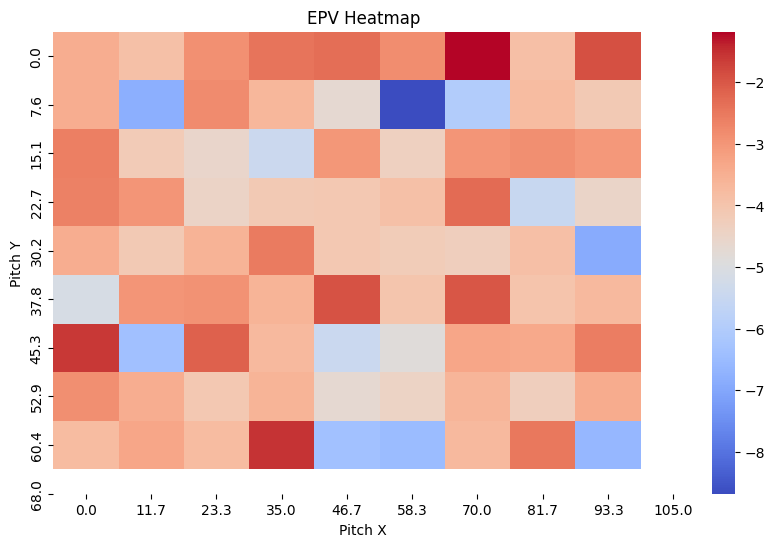

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated Event Data
np.random.seed(42)
n_samples = 10000
data = {
    "start_x": np.random.uniform(0, 105, n_samples),  # Start X-coordinates
    "start_y": np.random.uniform(0, 68, n_samples),  # Start Y-coordinates
    "end_x": np.random.uniform(0, 105, n_samples),  # End X-coordinates
    "end_y": np.random.uniform(0, 68, n_samples),  # End Y-coordinates
    "action_type": np.random.choice(["pass", "shot", "dribble"], n_samples),
    "outcome": np.random.choice(["goal", "possession", "loss"], n_samples, p=[0.05, 0.75, 0.2]),
}

df = pd.DataFrame(data)

# Add features
df["distance_to_goal"] = np.sqrt((105 - df["end_x"])**2 + (34 - df["end_y"])**2)
df["angle_to_goal"] = np.arctan2(34 - df["end_y"], 105 - df["end_x"])

# Encode target variable
df["goal"] = (df["outcome"] == "goal").astype(int)
df["loss"] = (df["outcome"] == "loss").astype(int)
df["possession_continuation"] = (df["outcome"] == "possession").astype(int)

# Feature and target selection
features = ["start_x", "start_y", "end_x", "end_y", "distance_to_goal", "angle_to_goal"]
targets = ["goal", "possession_continuation", "loss"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[targets], test_size=0.2, random_state=42
)

# Train models for probabilities
models = {}
for target in targets:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    models[target] = model

# Predict probabilities
probs = {target: models[target].predict_proba(X_test)[:, 1] for target in targets}

# Combine predictions into EPV
X_test["goal_prob"] = probs["goal"]
X_test["continuation_prob"] = probs["possession_continuation"]
X_test["loss_prob"] = probs["loss"]

X_test["epv"] = X_test["goal_prob"] - X_test["loss_prob"]

# Visualize EPV across the pitch
grid_size = 10
x_bins = np.linspace(0, 105, grid_size)
y_bins = np.linspace(0, 68, grid_size)

heatmap, xedges, yedges = np.histogram2d(
    X_test["end_x"], X_test["end_y"], bins=[x_bins, y_bins], weights=X_test["epv"]
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap.T, cmap="coolwarm", cbar=True,
    xticklabels=np.round(xedges, 1), yticklabels=np.round(yedges, 1)
)
plt.title("EPV Heatmap")
plt.xlabel("Pitch X")
plt.ylabel("Pitch Y")
plt.show()


In [7]:
import pandas as pd

# Load the Excel file
file_path = "Pass.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Verify the data
print(df.head())


   Unnamed: 0          id  eventId  typeId  periodId  timeMin  timeSec  \
0           0  2716319677        1      34        16        0        0   
1           1  2716320389        1      34        16        0        0   
2           2  2716367371        2      32         1        0        0   
3           3  2716367305        2      32         1        0        0   
4           4  2716367353        3       1         1        0        0   

                contestantId  outcome     x  ...  qualifier/21/id  \
0  24fvcruwqrqvqa3aonf8c3zuy        1   0.0  ...              NaN   
1  b79uipsy57y1jqpy07h4i5ovk        1   0.0  ...              NaN   
2  b79uipsy57y1jqpy07h4i5ovk        1   0.0  ...              NaN   
3  24fvcruwqrqvqa3aonf8c3zuy        1   0.0  ...              NaN   
4  24fvcruwqrqvqa3aonf8c3zuy        1  50.2  ...              NaN   

  qualifier/21/qualifierId qualifier/21/value  qualifier/22/id  \
0                      NaN                NaN              NaN   
1       

In [8]:
import numpy as np

# Add calculated features
df["distance_to_goal"] = np.sqrt((105 - df["endX"])**2 + (34 - df["endY"])**2)
df["angle_to_goal"] = np.arctan2(34 - df["endY"], 105 - df["endX"])

# Encode targets based on rules
df["goal"] = (df["typeId"] == 16).astype(int)
df["loss"] = (df["typeId"] == 9).astype(int)
df["possession_continuation"] = ((df["typeId"] == 1) & (df["outcome"] == 1)).astype(int)

# Verify the encoded columns
print(df[["typeId", "outcome", "goal", "loss", "possession_continuation"]].head())


   typeId  outcome  goal  loss  possession_continuation
0      34        1     0     0                        0
1      34        1     0     0                        0
2      32        1     0     0                        0
3      32        1     0     0                        0
4       1        1     0     0                        1


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Features and targets
features = ["x", "y", "endX", "endY", "distance_to_goal", "angle_to_goal"]
targets = ["goal", "possession_continuation", "loss"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[targets], test_size=0.2, random_state=42
)

# Train models for each outcome
models = {}
for target in targets:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    models[target] = model

# Predict probabilities
X_test["goal_prob"] = models["goal"].predict_proba(X_test[features])[:, 1]
X_test["continuation_prob"] = models["possession_continuation"].predict_proba(X_test[features])[:, 1]
X_test["loss_prob"] = models["loss"].predict_proba(X_test[features])[:, 1]

# Calculate EPV
X_test["epv"] = X_test["goal_prob"] - X_test["loss_prob"]

# Display the first few rows to verify
print(X_test[["goal_prob", "continuation_prob", "loss_prob", "epv"]].head())



IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

# Aggregate EPV by grid
grid_size = 10
x_bins = np.linspace(0, 105, grid_size)
y_bins = np.linspace(0, 68, grid_size)

heatmap, xedges, yedges = np.histogram2d(
    X_test["end_x"], X_test["end_y"], bins=[x_bins, y_bins], weights=X_test["epv"]
)

# Plot heatmap on pitch
sns.heatmap(
    heatmap.T, cmap="coolwarm", ax=ax, cbar=True,
    xticklabels=np.round(xedges, 1), yticklabels=np.round(yedges, 1)
)

# Set plot details
plt.title("EPV Heatmap on Pitch")
plt.show()


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Example: Load data from Excel (replace with your actual file path)
file_path = "Pass.xlsx"  # Replace with your actual file path
df = pd.read_excel(file_path)

# Check the first few rows and column names to verify
print(df.head())

# Calculate additional features
df["distance_to_goal"] = np.sqrt((105 - df["endX"])**2 + (34 - df["endY"])**2)  # Adjust goal coordinates
df["angle_to_goal"] = np.arctan2(34 - df["endY"], 105 - df["endX"])

# Encode target variables based on typeId and outcome
df["goal"] = (df["typeId"] == 16).astype(int)  # typeId == 16 indicates a goal
df["loss"] = (df["typeId"] == 9).astype(int)   # typeId == 9 indicates loss of possession
df["possession_continuation"] = ((df["typeId"] == 1) & (df["outcome"] == 1)).astype(int)  # typeId == 1 with outcome == 1

# Check the class distribution of the target variable to handle imbalances
print("Class distribution for 'goal':")
print(df["goal"].value_counts())

print("Class distribution for 'loss':")
print(df["loss"].value_counts())

print("Class distribution for 'possession_continuation':")
print(df["possession_continuation"].value_counts())

# Features and targets
features = ["x", "y", "endX", "endY", "distance_to_goal", "angle_to_goal"]
targets = ["goal", "possession_continuation", "loss"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[targets], test_size=0.2, random_state=42
)

# Train RandomForest models with class balancing
models = {}
for target in targets:
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")  # Handling class imbalance
    model.fit(X_train, y_train[target])
    models[target] = model

# Predict probabilities for each target (goal, possession_continuation, loss)
X_test["goal_prob"] = models["goal"].predict_proba(X_test[features])[:, 1]
X_test["continuation_prob"] = models["possession_continuation"].predict_proba(X_test[features])[:, 1]

# Check if 'loss' model predicts both classes or only one class
loss_prob = models["loss"].predict_proba(X_test[features])

# If only one class is predicted, handle accordingly
if loss_prob.shape[1] > 1:
    X_test["loss_prob"] = loss_prob[:, 1]
else:
    X_test["loss_prob"] = loss_prob[:, 0]  # In case the model predicts only one class

# Calculate EPV
X_test["epv"] = X_test["goal_prob"] - X_test["loss_prob"]

# Verify the results
print(X_test[["goal_prob", "continuation_prob", "loss_prob", "epv"]].head())

# Optionally, you can save the processed results to a new Excel file
output_path = "processed_ERE.xlsx"
X_test.to_excel(output_path, index=False)
print(f"Processed data saved to {output_path}")


   Unnamed: 0          id  eventId  typeId  periodId  timeMin  timeSec  \
0           0  2716319677        1      34        16        0        0   
1           1  2716320389        1      34        16        0        0   
2           2  2716367371        2      32         1        0        0   
3           3  2716367305        2      32         1        0        0   
4           4  2716367353        3       1         1        0        0   

                contestantId  outcome     x  ...  qualifier/21/id  \
0  24fvcruwqrqvqa3aonf8c3zuy        1   0.0  ...              NaN   
1  b79uipsy57y1jqpy07h4i5ovk        1   0.0  ...              NaN   
2  b79uipsy57y1jqpy07h4i5ovk        1   0.0  ...              NaN   
3  24fvcruwqrqvqa3aonf8c3zuy        1   0.0  ...              NaN   
4  24fvcruwqrqvqa3aonf8c3zuy        1  50.2  ...              NaN   

  qualifier/21/qualifierId qualifier/21/value  qualifier/22/id  \
0                      NaN                NaN              NaN   
1       

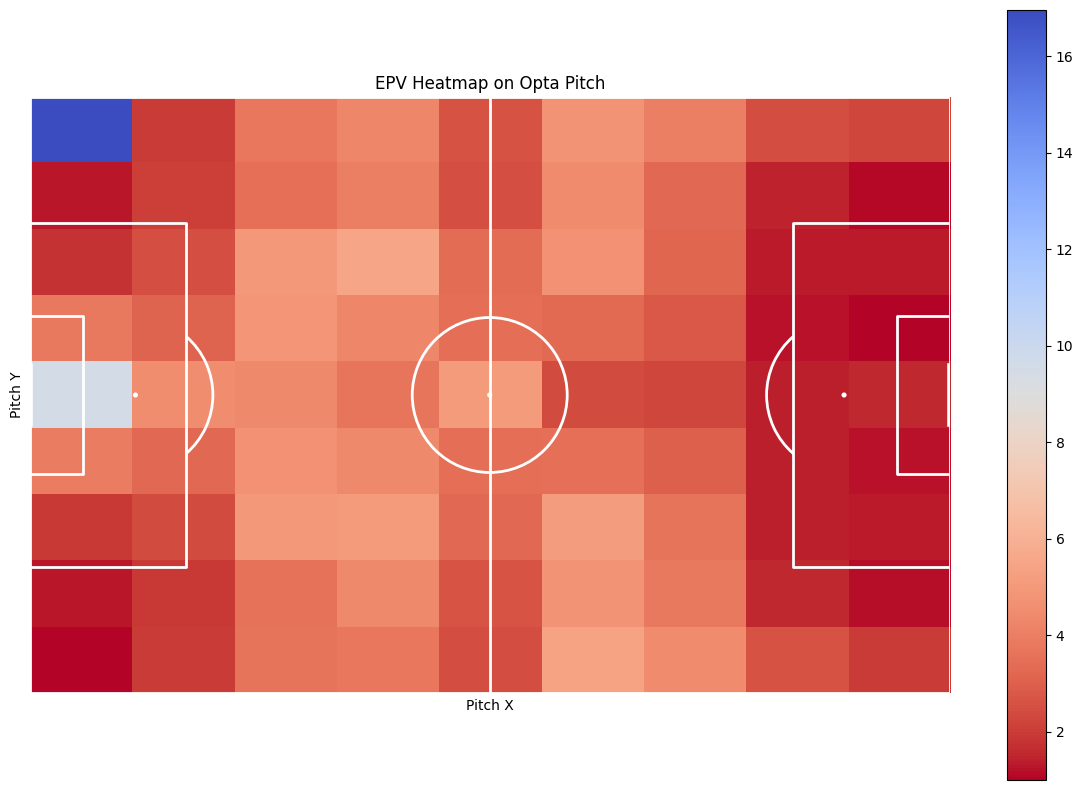

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Define grid size and bins for pitch areas (split pitch into smaller cells)
grid_size = 10  # Adjust the grid size if needed
x_bins = np.linspace(0, 100, grid_size)  # Opta pitch width (scaled to 100)
y_bins = np.linspace(0, 100, grid_size)  # Opta pitch height (scaled to 100)

# Calculate the 2D histogram of EPV values based on the position of the event's end (end_x, end_y)
# Note that X_test["y"] corresponds to the height (y), and X_test["x"] corresponds to the width (x)
heatmap, xedges, yedges = np.histogram2d(
    X_test["x"], X_test["y"], bins=[x_bins, y_bins], weights=X_test["epv"]
)

# Normalize the heatmap to a 0-1 range for better color mapping
heatmap = heatmap / np.max(heatmap)

# Create a Pitch object with Opta pitch layout
pitch = Pitch(pitch_type='opta', pitch_color='green', line_color='white')

# Create the figure and axis with constrained layout
fig, ax = pitch.draw(figsize=(12, 8), constrained_layout=True)

# Plot the heatmap using imshow for better aspect control
im = ax.imshow(
    heatmap.T,  # Transpose because `imshow` expects rows as y and columns as x
    cmap="coolwarm_r",  # Reversed color map: warmer colors for higher values
    extent=[0, 100, 0, 100],  # Match the Opta pitch bounds (0-100 for x and y)
    origin="lower",  # Ensure the origin starts from the bottom left
)

# Adjust the aspect ratio manually to reflect a football pitch's dimensions (105x68)
ax.set_aspect(68 / 105)  # Now y-axis (height) will correspond to the 105m width

# Adjust the x and y axis limits to match the pitch dimensions
ax.set_xlim(0, 100)  # Set the limits of x-axis (pitch width)
ax.set_ylim(0, 100)  # Set the limits of y-axis (pitch height)

# Reverse the axes to match the typical football pitch view
ax.invert_yaxis()
#ax.invert_xaxis()

# Add title and labels
plt.title("EPV Heatmap on Opta Pitch")
plt.xlabel("Pitch X")  # X-axis is now the width of the pitch (horizontal)
plt.ylabel("Pitch Y")  # Y-axis is now the height of the pitch (vertical)

# Show the colorbar
fig.colorbar(im, ax=ax, orientation='vertical')

# Show the plot
plt.show()


In [65]:
import pandas as pd
import numpy as np

# Load the Excel file
file_path = "Pass.xlsx"  # Replace with your Excel file's path
player_data = pd.read_excel(file_path)

# Interpolate the EPV value for each action using the heatmap
def get_epv(x, y, heatmap, xedges, yedges):
    x_idx = np.searchsorted(xedges, x, side="right") - 1
    y_idx = np.searchsorted(yedges, y, side="right") - 1
    
    # Ensure indices are within bounds
    x_idx = np.clip(x_idx, 0, heatmap.shape[0] - 1)
    y_idx = np.clip(y_idx, 0, heatmap.shape[1] - 1)
    
    return heatmap[x_idx, y_idx]

# Add EPV values for each action
player_data["epv"] = player_data.apply(
    lambda row: get_epv(row["x"], row["y"], heatmap, xedges, yedges), axis=1
)

# Aggregate EPV per playerName
epv_per_player = player_data.groupby("playerName")["epv"].sum().reset_index()
epv_per_player.columns = ["playerName", "total_epv"]

# Display results
print(epv_per_player)

# Save the results to a new Excel file (optional)
output_file = "epv_per_player.xlsx"
epv_per_player.to_excel(output_file, index=False)
print(f"EPV per player saved to {output_file}")


         playerName    total_epv
0      A. Adelgaard  2098.974447
1          A. Blake   292.768171
2          A. Condé  1687.003214
3        A. Darelas   184.201162
4       A. Descotte   741.247319
..              ...          ...
442    Zidane Iqbal  2077.239715
443  Àlex Carbonell  1075.665375
444     Álex Balboa  1017.431505
445       É. Michut   109.305656
446    Úmaro Embaló    41.424770

[447 rows x 2 columns]
EPV per player saved to epv_per_player.xlsx
